# Agglomerative Clustering

In [2]:

!pip install -U scikit-learn

First thing first, let's use the generator tools from previous works

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.cluster import AgglomerativeClustering as agg

def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster


def plot_loss(loss):
    plt.figure()
    plt.plot(range(len(loss)),loss)
    plt.title("loss vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|loss|")
    plt.show()

def get_rand_centroids(K,d):
    centroids = np.random.rand(K, d)
    return centroids

In [42]:

def generate_clusters(k, d = 2,N = 600, distance = 2):
    """
    generate k clusters of d-dimensional data

    :param k:           number of clusters
    :param d:           dimension of the data
    :param distance:    expected distance of the mean from the origin
    :return:            clusters - a list of clusters, where each cluster is a numpy array of datapoints
                        data - a numpy array of all the datapoints
                        phi - a numpy array of the priors of each cluster
                        sigma - a numpy array of the covariance matrices of each cluster
    """
    phi = np.random.rand(k)
    phi = phi/np.sum(phi)
    print(phi)

    # random distributions
    distributions = [get_random_gaussian_dist(d,distance) for i in range(k)]
    print(distributions[0])
    # generate clusters
    clusters = [generate_gaussian_cluster(distribution,int(phi[i]*N),d) for i, distribution in enumerate(distributions)]

    sigma = [distribution[1] for distribution in distributions]
    data = np.concatenate(clusters,axis=0)

    return clusters, data, phi, sigma



def plot_clusters(clusters, d = 2,title = None,ax = None):

    """
    Function to plot the clusters
    input: clusters - a list of clusters, where each cluster is a numpy array of datapoints
           d - the dimension of the data
    output: a plot of the clusters, where each cluster is a different color, and the datapoints are transparent to show overlapping clusters

    """
    if not ax:
        plt.figure()
    if d == 2:
        for c in clusters:
            plt.scatter(c[:,0], c[:, 1], alpha=0.5)
    else:
        #ax = plt.axes(projection='3d')

        for c in clusters:
            ax.scatter3D(c[:,0], c[:, 1], c[:, 2], alpha=0.5)
    if title:
        plt.title(title)


def plot_centroids(centroids, d = 2,title = None):
    """
    Function to plot the centroids
    input: centroids - a numpy array of centroids
           d - the dimension of the data
    output: a plot of the centroids, where each centroid is a different color

    """
    if d == 2:
        for c in centroids:
            plt.scatter(c[0],c[1],marker='x',s=100)
    else:
        for c in centroids:
            ax.scatter3D(c[0], c[1], c[2], marker='x', s=100)


In [6]:
def get_gaussian_line_shape_distribution(p1,p2):
    v = p2 - p1
    v_norm = np.linalg.norm(v)
    u = v/v_norm

    sigma = v_norm * np.outer(u,u)

    epsilon = 0.005 * np.identity(sigma.shape[0])
    sigma +=epsilon

    mu = p1 + (p2 - p1)/2

    return mu, sigma



In [136]:
def get_gaussian_line_shape_distribution(p1,p2):
    v = p2 - p1
    v_norm = np.linalg.norm(v)
    u = v/v_norm

    sigma = v_norm * np.outer(u,u)

    epsilon = 0.005 * np.identity(sigma.shape[0])
    sigma +=epsilon

    mu = p1 + (p2 - p1)/2

    return mu, sigma

def generate_polygon(n,P,d):
    labels = []
    clusters = np.empty((0,d))
    # for k clusters:
    for i,p in enumerate (P):
        cluster = generate_gaussian_cluster(get_gaussian_line_shape_distribution(P[i-1],p),n[i], d=d)
        clusters = np.append(clusters,cluster, axis=0)

        labels += [i]*n[i]

    return clusters, labels


## generate the data

In [183]:

K = 7
d = 2
N = 1000
distance = 8
max_iters = 50

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)

[0.15656465 0.16095903 0.08379894 0.20353774 0.16390747 0.02580139
 0.20543077]
(array([7.92180782, 3.82793914]), array([[0.16072146, 0.07432678],
       [0.07432678, 0.03451927]]))


## plot the data

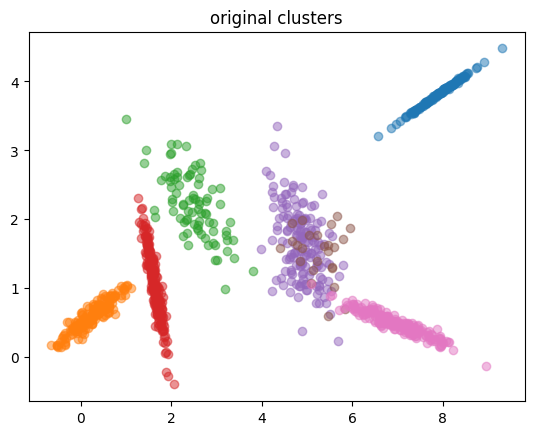

In [184]:
plot_clusters(clusters,d,title="original clusters")

# Agglomerative clustering

Aggumulative clustering is a bottom-up approach to clustering. The algorithm starts with each datapoint as a cluster, and then merges the two closest clusters iteratively until the desired number of clusters is reached, according to some distance metric.

the algorithm runs acording to the following pseudo-code:
#####   Input:

- data: A set of n data points, where data = {x1, x2, ..., xn}
- distance_function: A function that calculates the distance between two clusters, for example, d(ci, cj) denotes the distance between clusters ci and cj.
#####   Output:

- clusters: A set of clusters obtained from the agglomerative clustering algorithm.

##### Initialization:

Initialize $n$ clusters, each containing a single data point: $ci = {xi}$ for $i \in \{1... n\}$.
Compute the distance matrix D with D[i, j] = distance_function(ci, cj) for all pairs of clusters.

##### Agglomerative Cluster($K$, data $x$, distance_function $f$):
While the number of clusters is greater than 1, do the following:

1. Find the two closest clusters ca and cb based on the distance matrix $D$:
$$c_a, c_b = argmin_{c_i, c_j} D[i, j]$$

2. Merge the closest clusters $c_a$ and $c_b$ into a new cluster c_new:
$$c_{new} = c_a ∪ c_b$$

3. Update the distance matrix $D$ to reflect the new distances between the merged cluster $c_new$ and the remaining clusters:
$D[new, k]$ = $f(c_{new}, c_k)$ for all clusters ck in the remaining clusters

Remove the rows and columns corresponding to $c_a$ and $c_b$ from $D$.

##### Output:
Return the final set of clusters after the algorithm terminates.



In [179]:
def agglomerative_cluster(data, K, linkage='ward',plot = False):
    """
    :param data:
    :param n_clusters:
    :param linkage:
    :return:
    """
    clustering = agg()
    clustering.n_clusters = K
    clustering.linkage = linkage
    clustering.fit(data)

    labels = clustering.labels_

    clusters = [data[labels == i] for i in range(K)]
    if plot:
        plot_clusters(clusters,d,title="Agglomerative clustering")
    return clusters

def agglomerative_cluster_plot_steps(data, K, linkage='ward',steps = None):
    """
    :param data:
    :param n_clusters:
    :param linkage:
    :return:
    """
    clustering = agg()
    n_steps = 5
    if not steps:
        steps = [K + 5*(n_steps-1-k) for k in range(n_steps)]
    for k in range(len(steps)):
        clustering.n_clusters = steps[k]
        clustering.linkage = linkage
        clustering.fit(data)
        labels = clustering.labels_

        clusters = [data[labels == i] for i in range(steps[k])]

        plot_clusters(clusters,d,title=f" {steps[k]} components")
        plt.pause(0.5)
        plt.clf()

    return clusters



## try the algorithm on a data

here we will try the algorithm on the data we generated above, and see how it performs. it is a dataset consisting of 7 clusters, 1000 2D data points, and the clusters are separated by a mean distance of 6, which creates a noticeable distinction. we will try to cluster the data into 7 clusters, and see how the algorithm performs.


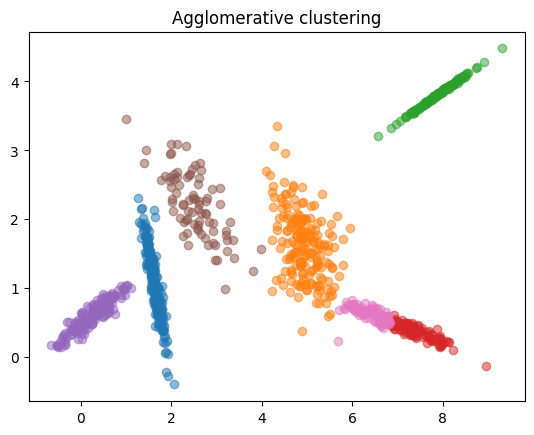

In [186]:

clusters = agglomerative_cluster(data,K)
plot_clusters(clusters,d,title="Agglomerative clustering")


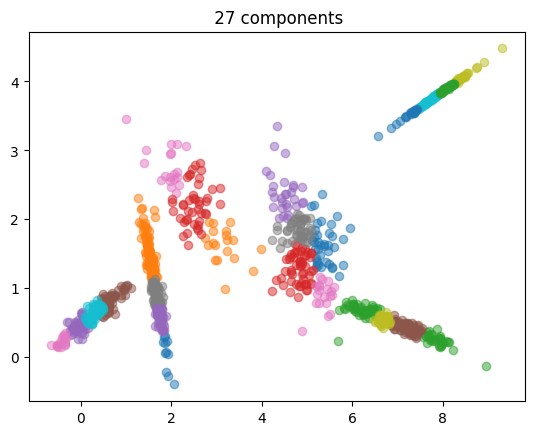

<Figure size 640x480 with 0 Axes>

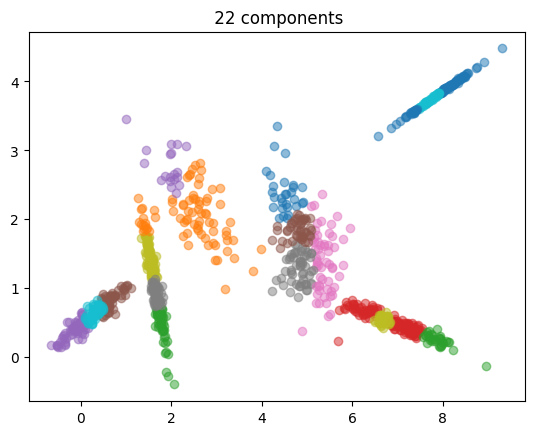

<Figure size 640x480 with 0 Axes>

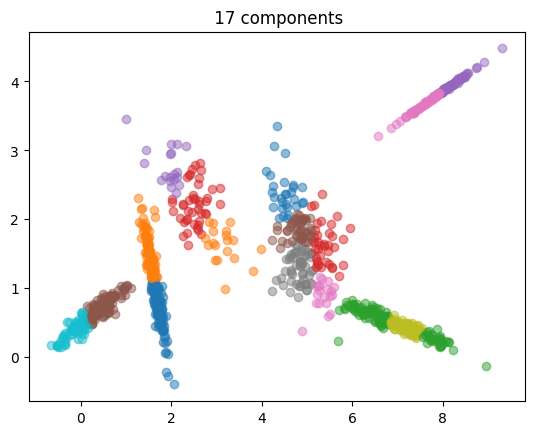

<Figure size 640x480 with 0 Axes>

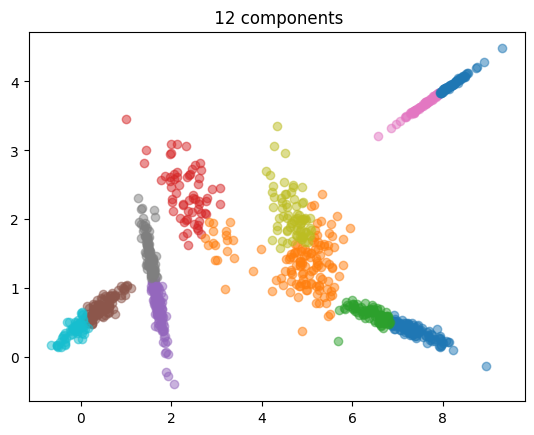

<Figure size 640x480 with 0 Axes>

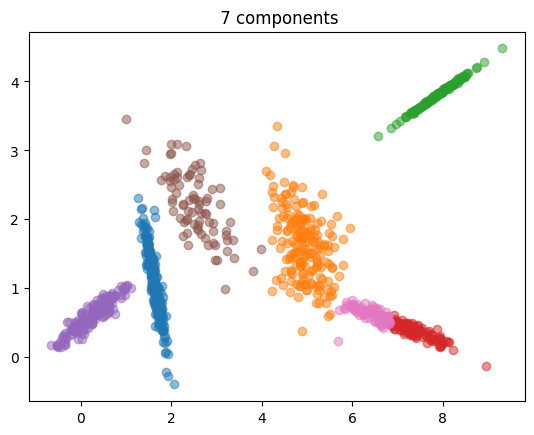

<Figure size 640x480 with 0 Axes>

In [187]:

clusters = agglomerative_cluster_plot_steps(data,K)

## results

# different distance metrics
in the agglomerative clustering algorithm, we need to define a distance metric between two clusters for finding the two clusters to unify in step 1. note that the distance metric is not the same as the distance metric between two points $d_{i,j}$, rather it is a distance metric between two cluster of datapoints $d_
{metric}(C_i,C_j)$, as we would like to find the two clusters to unify in this step. choosing linkage metric shuld reflect the nature of the data and the specific characteristics of clusters we expect to find. There is no one-size-fits-all answer, and one should try different linkage methods and compare their clustering outputs using his own validation methods.

 There are several options for this metric, and we will discuss four of them, as presented in class, and try each on the same dataset

## $d_{min}$

this distance metric is also known as the single linkage distance. It is defined as the distance between the two closest points in the two clusters. Formally, it is defined as: $$d_{min}(c_i, c_j) = min_{x_i \in c_i, x_j \in c_j} ||x_i, x_j||$$
advantages : It can detect elongated clusters and is less sensitive to outliers.
disadvantagae : It suffers from the "chaining" effect, as we will se in the next sections, where clusters can be connected as long chains, leading to long and straggly clusters.



### try the distance measure

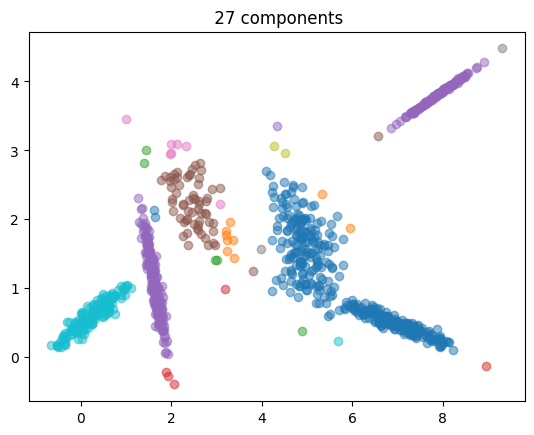

<Figure size 640x480 with 0 Axes>

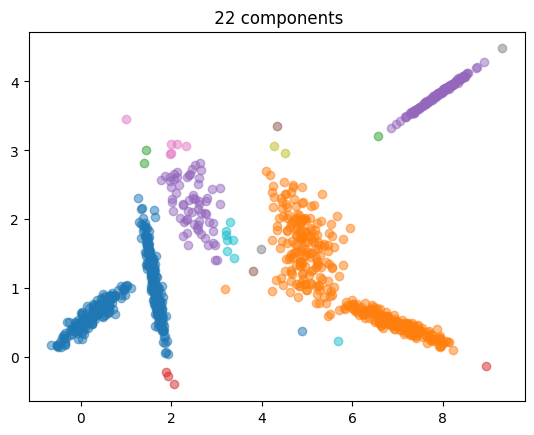

<Figure size 640x480 with 0 Axes>

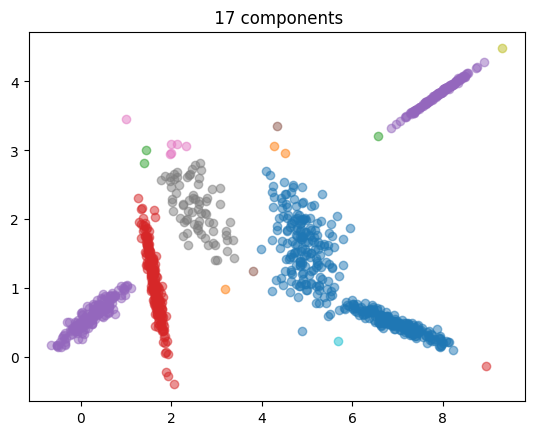

<Figure size 640x480 with 0 Axes>

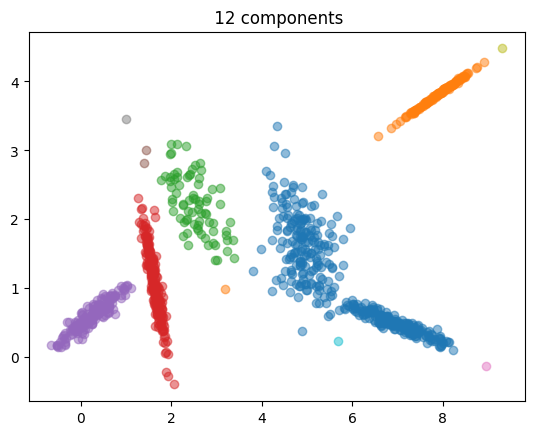

<Figure size 640x480 with 0 Axes>

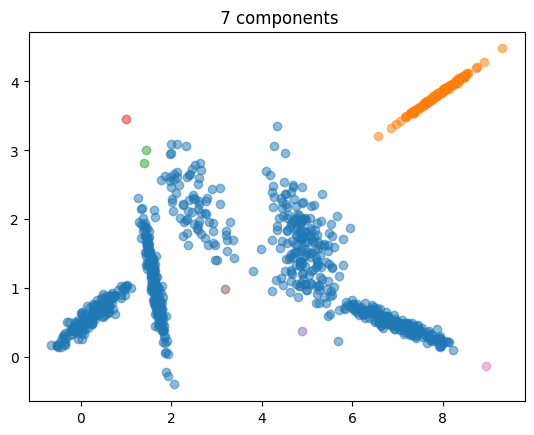

<Figure size 640x480 with 0 Axes>

In [185]:

clusters = agglomerative_cluster_plot_steps(data,K, linkage='single')


### results
we applied the single linkage method to a 7-cluster dataset, resulting in the merging of four original clusters and the allocation of some outliers to their own clusters. Single linkage's sensitivity to elongated clusters and its preference for small, isolated clusters contributed to these clustering outcomes.

## $d_{max}$

this linkage uses the maximum distances between all observations of the two sets. it seems counterintuitive to use the max distance, but we calculate it in order to merge clusters whose two farthest data points have the smallest distance.
$$d_{max}(C_i, C_j) = max_{u \in C_i, v \in C_j} dist(u, v)$$
Pros: It is less affected by outliers and is capable of detecting compact and spherical clusters.
Cons: It can create clusters of relatively equal diameter, and it may not perform well for elongated or irregularly shaped clusters.


### run the algorithm

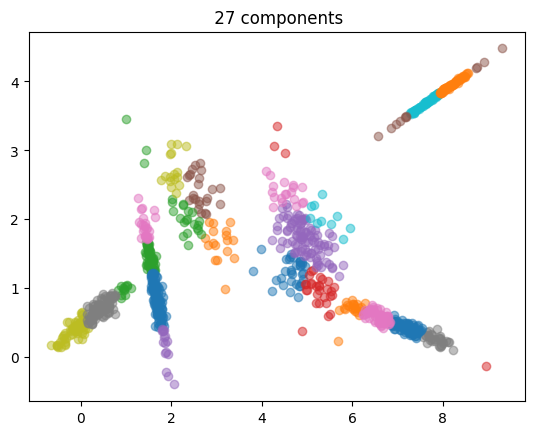

<Figure size 640x480 with 0 Axes>

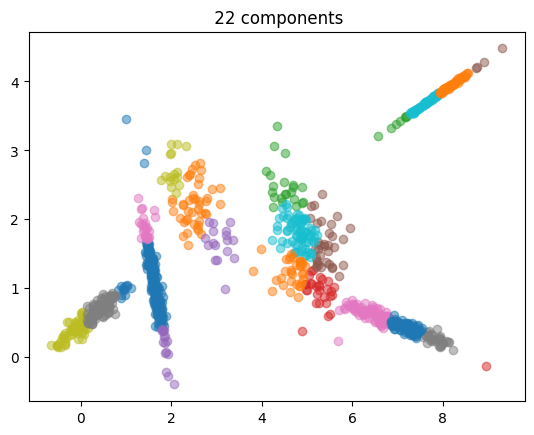

<Figure size 640x480 with 0 Axes>

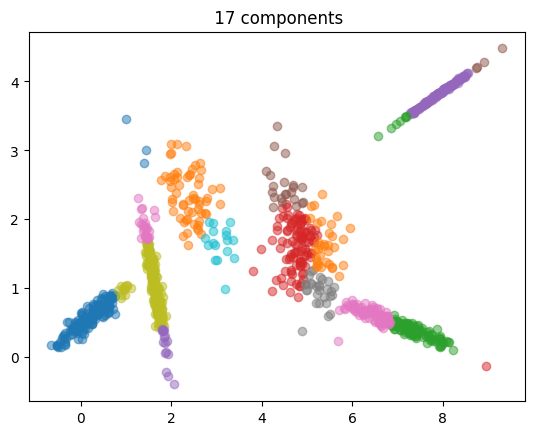

<Figure size 640x480 with 0 Axes>

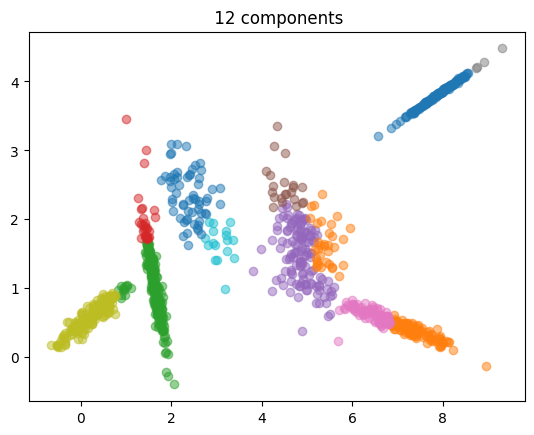

<Figure size 640x480 with 0 Axes>

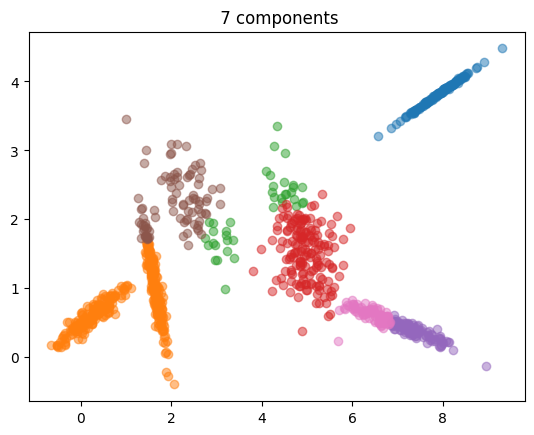

<Figure size 640x480 with 0 Axes>

In [188]:
clusters = agglomerative_cluster_plot_steps(data,K,'complete')



### results
here we employed the complete linkage method on the same 7-cluster dataset, which yielded the formation of elongated clusters separated into distinct "stripes." Complete linkage's preference for compact and spherical clusters contributed to this clustering pattern, emphasizing the cohesive nature of the resulting stripes.

## $d_{avg}$
 in this metric, we merge clusters based on the average proximity of all pairs of data points from the two clusters.
$$d_{avg}(C_i, C_j) = \frac{1}{n_i \cdot n_j} \sum_{u \in C_i} \sum_{v \in C_j} dist(u, v)$$

 advantage: It strikes a balance between single and complete linkage and is less sensitive to outliers.
disadvantage: It can still suffer from the "chaining" effect, but to a lesser extent compared to single linkage.



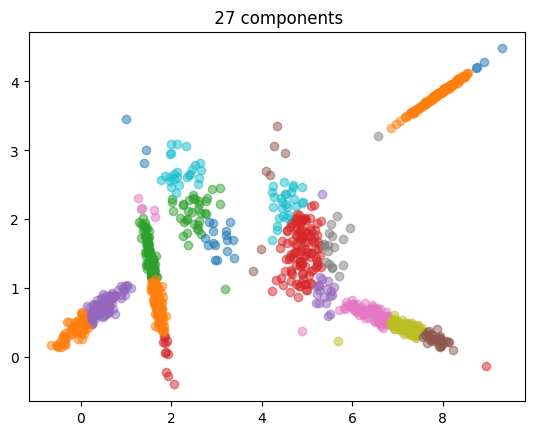

<Figure size 640x480 with 0 Axes>

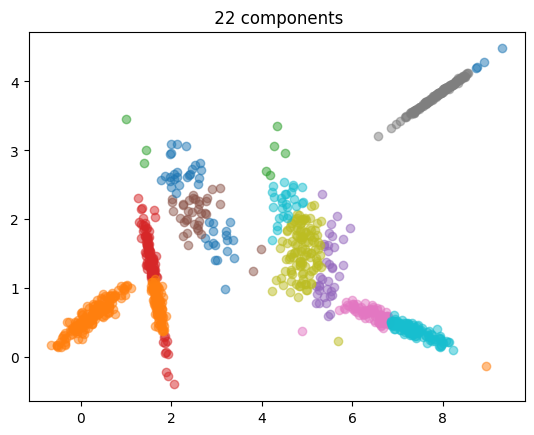

<Figure size 640x480 with 0 Axes>

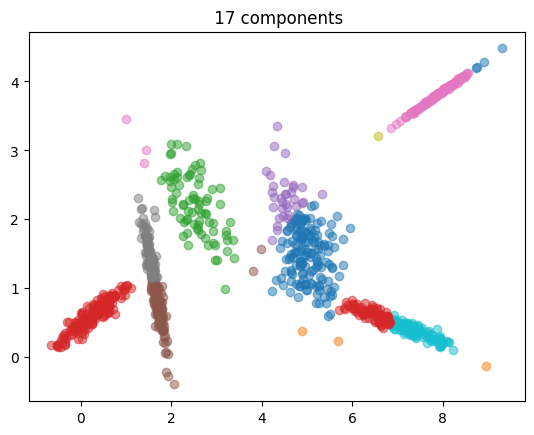

<Figure size 640x480 with 0 Axes>

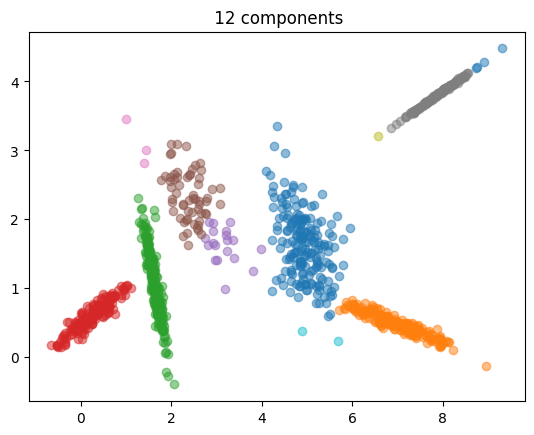

<Figure size 640x480 with 0 Axes>

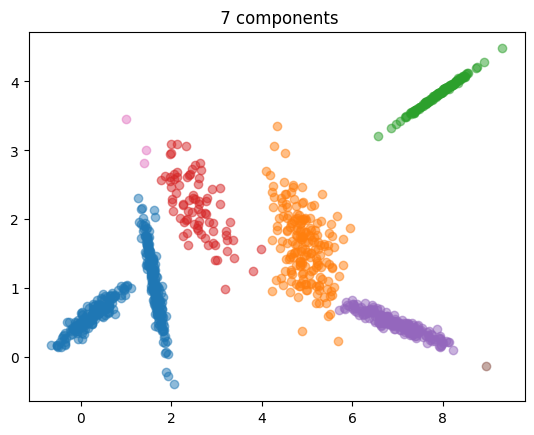

<Figure size 640x480 with 0 Axes>

In [189]:
clusters = agglomerative_cluster_plot_steps(data,K,'average')

## $d_{mean}$
in this metric, we use the norm of the distance of means of each two cluster as our linkage metric, when the idea is to ultimately try to minimize the variance within each cluster when merging two clusters. It calculates the increase in the total sum of squares after merging two clusters.
there are two common ways to calculate $d_mean$, normalized, and un normalized.
$$ d_{mean}(C_i, C_j) =  ||c_i - c_j||$$
$$ d_{mean}'(C_i, C_j) = \alpha \cdot ||c_i - c_j||$$
where - $ \alpha = \sqrt{\frac{n_i \cdot n_j}{n_i + n_j}}$
Pros: It tends to produce more balanced and compact clusters.
Cons: It is sensitive to outliers, and the resulting clusters may not always be visually apparent.

### run the algorithm with mean distance metric

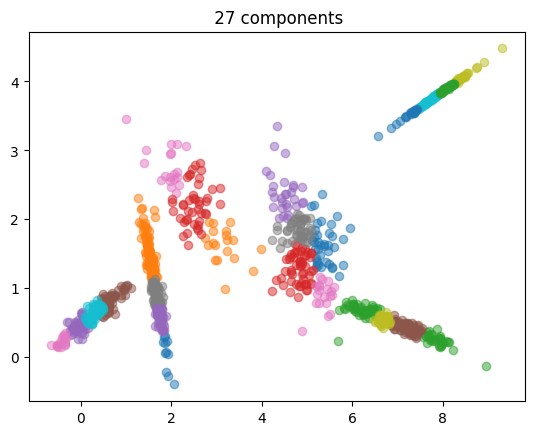

<Figure size 640x480 with 0 Axes>

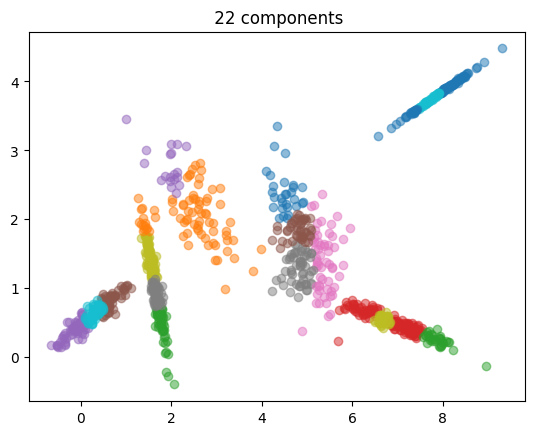

<Figure size 640x480 with 0 Axes>

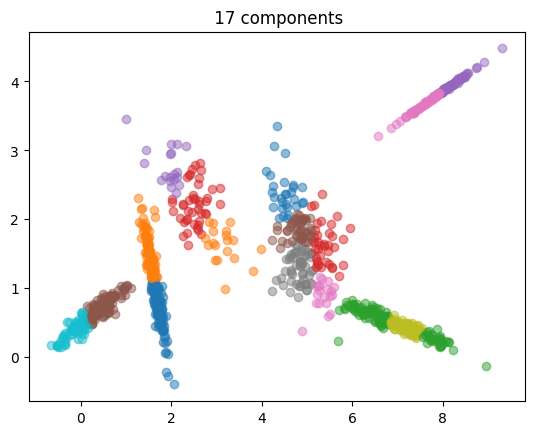

<Figure size 640x480 with 0 Axes>

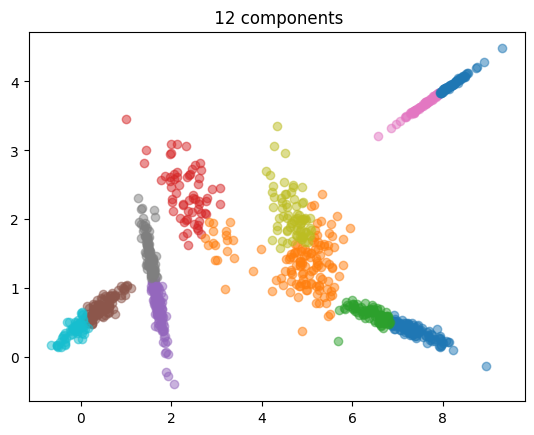

<Figure size 640x480 with 0 Axes>

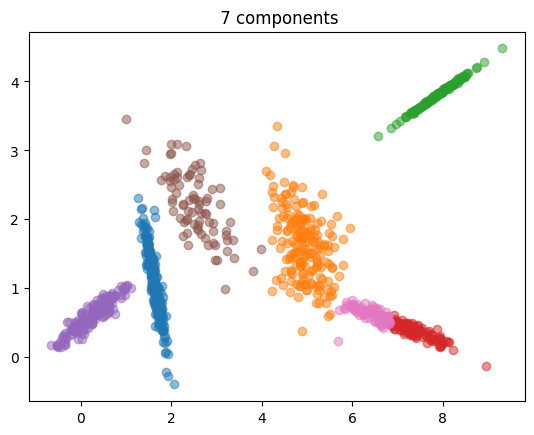

<Figure size 640x480 with 0 Axes>

In [190]:
clusters = agglomerative_cluster_plot_steps(data,K)

### results
with the mean metric, the clustering results on the 7-cluster dataset exhibited remarkable performance, nearly reproducing the original clusters. However, it encountered challenges when dealing with two blended together clusters, resulting in their merging, it also split one of the clusters into two halves due to its sensitivity to the variance minimization criterion. mean metric perfoemed best on this dataset

# 2nd Dataset: 3D data
here we will use a simple 3D dataset, and try to cluster it into 3 clusters. we will try the different distance metrics, and compare the results. different from before, we will  see how the algorthm deals with 2 or more clusters that are close to each other, or even collide.

## Generate the data

In [215]:
K = 3
d = 3
N = 1000
distance = 4

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)
print(len(clusters))

[0.3289259  0.20690634 0.46416776]
(array([2.898973  , 2.06282191, 0.44534766]), array([[ 0.02819278,  0.01977459,  0.00490907],
       [ 0.01977459,  0.3883222 , -0.23382559],
       [ 0.00490907, -0.23382559,  0.2103262 ]]))
3


## plot the data

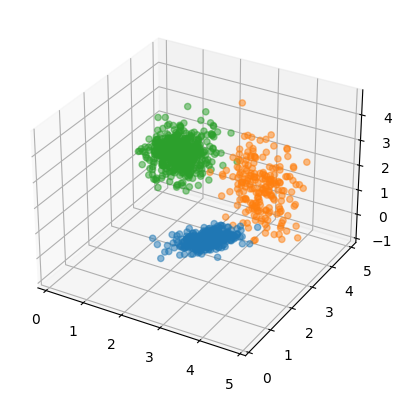

In [216]:
plot_clusters(clusters,d)

## run the algorithm

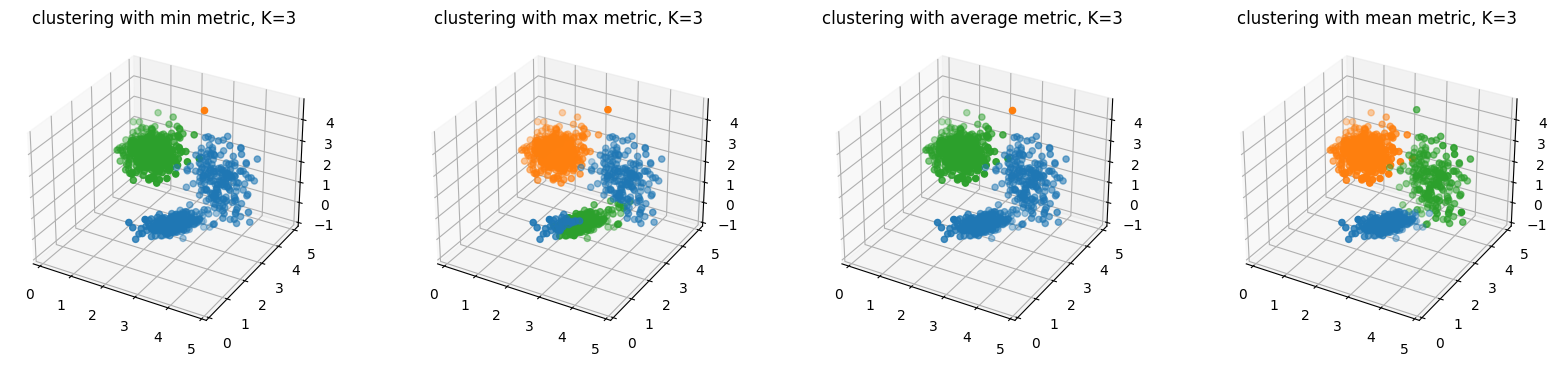

In [217]:
def compare_linkage_metrics(data,K):
    cluster_sets =[]
    cluster_sets.append( agglomerative_cluster(data,K,linkage='single') )
    cluster_sets.append( agglomerative_cluster(data,K,linkage='complete') )
    cluster_sets.append( agglomerative_cluster(data,K,linkage='average') )
    cluster_sets.append( agglomerative_cluster(data,K,linkage='ward') )

    d = data.shape[1]
    linkage = ['min','max','average','mean']
    fig = plt.figure(figsize=(20,4))
    for i in range(4):
        ax = fig.add_subplot(1,4,i+1, projection='3d' if d==3 else None)
        for j in range(K):
            if d == 2:
                ax.scatter(cluster_sets[i][j][:,0],cluster_sets[i][j][:,1],alpha=0.5)
            else:
                ax.scatter(cluster_sets[i][j][:,0],cluster_sets[i][j][:,1],cluster_sets[i][j][:,2])
        ax.set_title(f"clustering with {linkage[i]} metric, K={K}")

compare_linkage_metrics(data,K)


## what happend in the 'min' metric?
let's investigate the reason for the unification of the two clusters

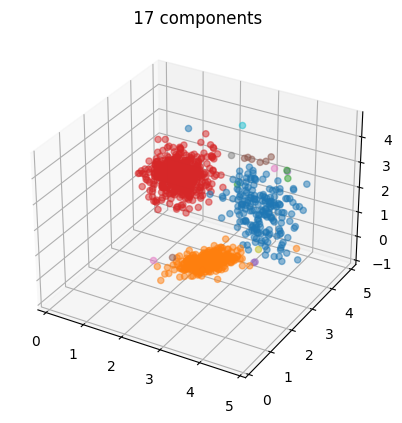

<Figure size 640x480 with 0 Axes>

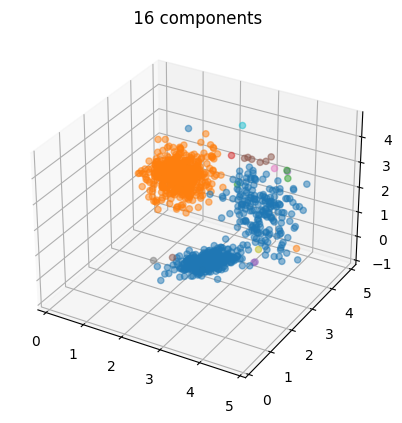

<Figure size 640x480 with 0 Axes>

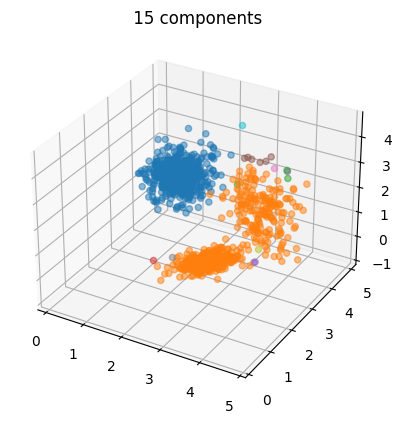

<Figure size 640x480 with 0 Axes>

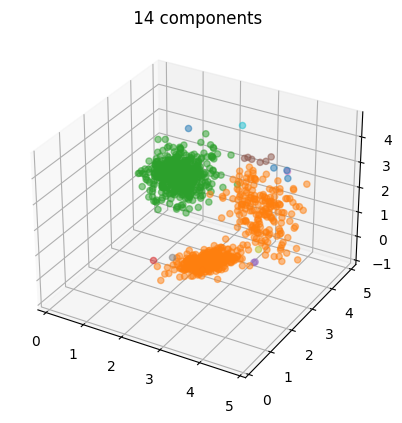

<Figure size 640x480 with 0 Axes>

In [220]:
steps =  [17,16,15,14]

clusers = agglomerative_cluster_plot_steps(data,K,linkage='single',steps=steps)

it seems that the two clusters are unified on the 17'th step (counting from the end) due to the proximity of two datapoints of the two, demonstrating the effect discussed earlier. outling points, however remain as isolated clusters

## the progress of the mean metric

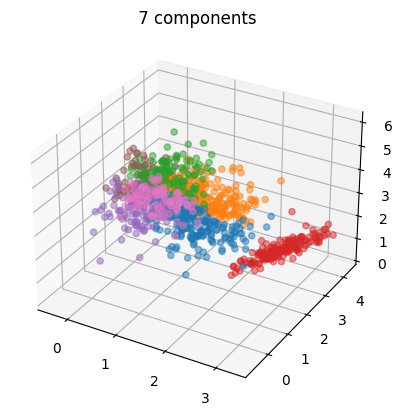

<Figure size 640x480 with 0 Axes>

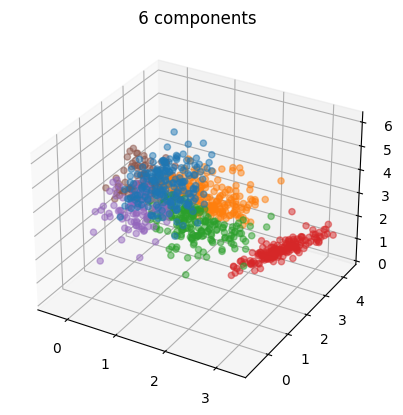

<Figure size 640x480 with 0 Axes>

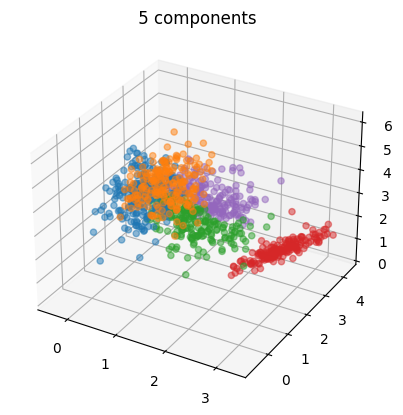

<Figure size 640x480 with 0 Axes>

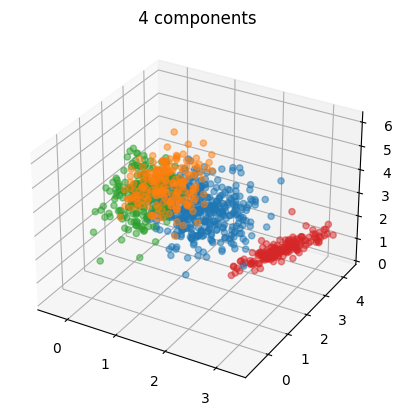

<Figure size 640x480 with 0 Axes>

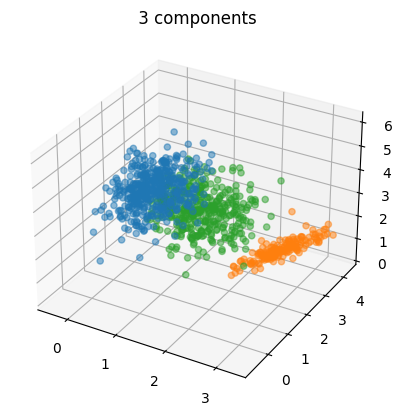

<Figure size 640x480 with 0 Axes>

In [92]:
steps =  [7,6,5,4,3]

clusers = agglomerative_cluster_plot_steps(data,K,linkage='ward',steps=steps)

## results

we see that in opposed to the min metric, in this case clusters remain balanced in size and shape, allowing the algorithm to converge to almost the exact original clustering

# 3rd Dataset: dense clusters of various sizes

In [102]:
K = 5
d = 3
N = 1000
distance = 4

clusters3, data3, phi, sigma = generate_clusters(K,d,N=N,distance=distance)
print(len(clusters))

[0.13033901 0.18493674 0.10117467 0.32359647 0.25995312]
(array([0.48136176, 0.39414907, 3.02985009]), array([[0.05614114, 0.01547768, 0.05711431],
       [0.01547768, 0.10652215, 0.00887812],
       [0.05711431, 0.00887812, 0.06259267]]))
3


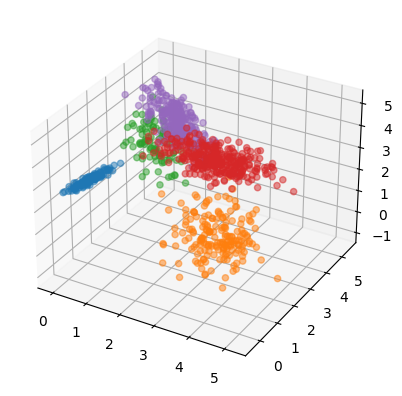

In [103]:
plot_clusters(clusters3,d)

## run the algorithm

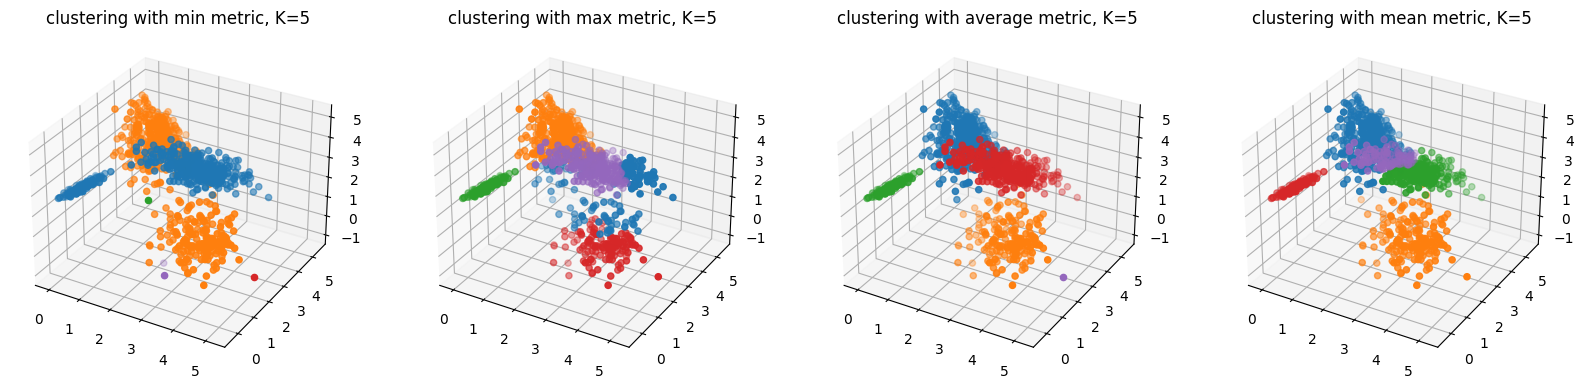

In [104]:
compare_linkage_metrics(data3,K)


### False unifications, False splits

here we see the trade-off between false unifications and false splits is a fundamental aspect in hierarchical clustering algorithms, including single linkage, complete linkage, and Ward's linkage. It revolves around the sensitivity of each linkage method to different cluster shapes and structures in the data. The choice of linkage method in hierarchical clustering involves a trade-off between false unifications and false splits. Single linkage, being more sensitive to chaining, is more likely to merge clusters that should remain separate (false unifications). In contrast, complete linkage and Ward's linkage, which focus on compact and spherical clusters or minimizing variance, respectively, may encounter false splits.



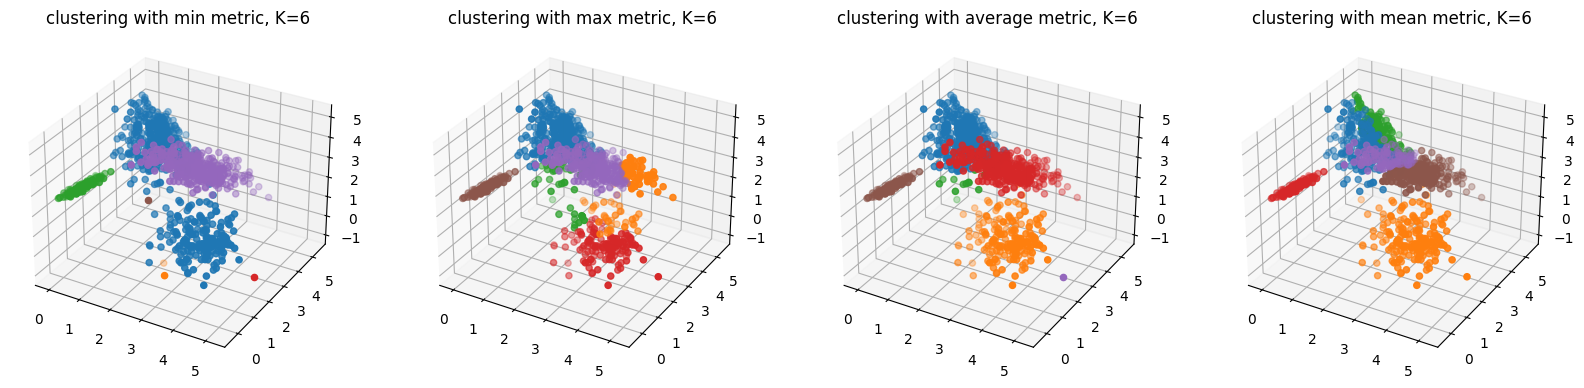

In [107]:
compare_linkage_metrics(data3,K+1)


## results

however, trying a larger $k$ value might reveal some of the false unifications, the more improbable the unification is, the further on it will happen in the algorithm, and the easier it is to detect.

# 4th Dataset: 2D data with 2 clusters

## generate the data


In [129]:
K = 2
d = 2
N = 1000
distance = 2

clusters4, data4, phi, sigma = generate_clusters(K,d,N=N,distance=distance)


[0.71667511 0.28332489]
(array([0.97152224, 0.60680312]), array([[0.35764408, 0.13462181],
       [0.13462181, 0.23847788]]))


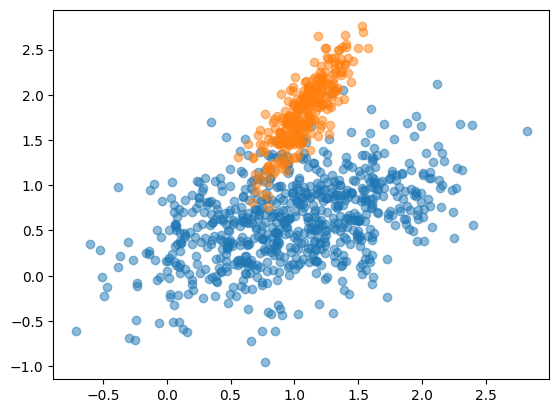

In [130]:
plot_clusters(clusters4,d)

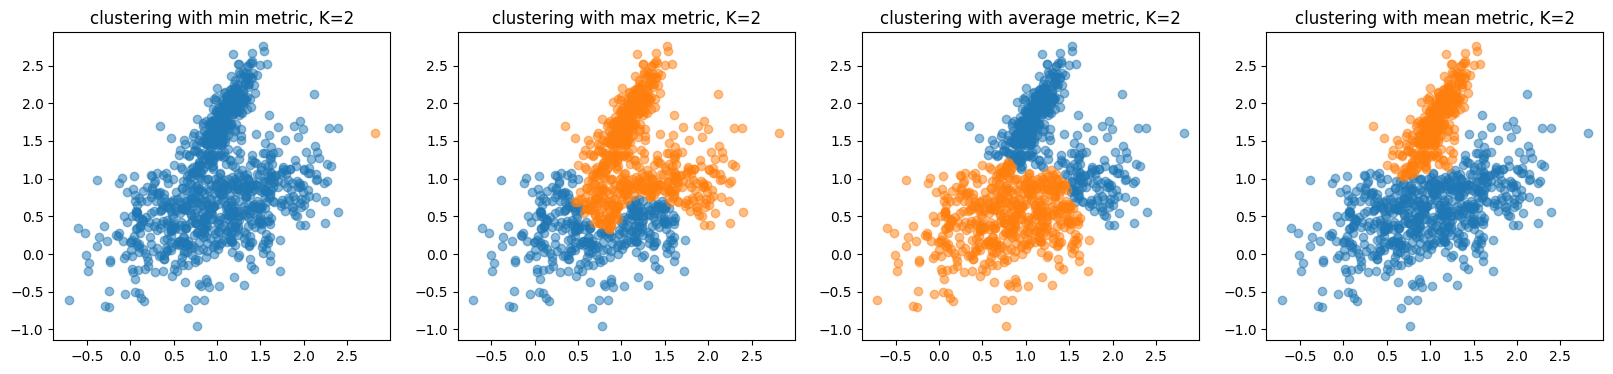

In [131]:
compare_linkage_metrics(data4,K)

## results

we tried all of the metrics on another dataset, one of the dofficulties with the avarage metric can be ssen, approx 1/5 of the points of the "big" cluster, are on avarage closer to the points of the other cluster, making the algorithm assign them with the wrong label

# 5th Dataset: star shaped data

let's try our star shaped data from the first notebook

[[-0.85711366 -5.45183584  6.01520689]
 [-0.72541901 -5.61833844  6.06647156]
 [-0.7811699  -7.25274091  6.483659  ]
 ...
 [ 0.16225344 -5.66760464  1.73776341]
 [ 0.0585352  -5.89638142  2.54880707]
 [ 0.14566137 -5.64634617  2.12440054]]


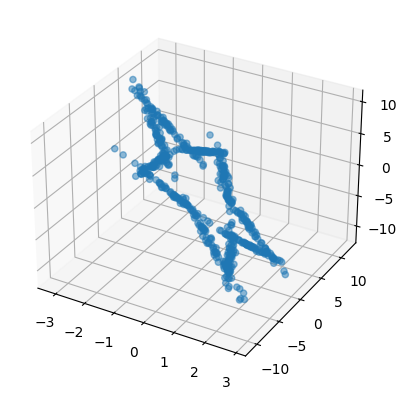

In [143]:
theta = np.linspace(0, 2*np.pi, 10, endpoint=False)
r = np.array([5,10,5,10,5,10,5,10,5,10])
x = r * np.cos(theta)
y = r * np.sin(theta)
z = np.zeros_like(theta)

points = np.array([[x[i],y[i],z[i]] for i in range(10)])

rotation = np.array([[-0.2018353 , -0.23967206,  0.94967418],
                     [-0.16056322,  0.97078361,  0.17884672],
                     [-0.96620219, -0.0075852 , -0.25795524]])
points = points @ rotation
d,labels = generate_polygon([60]*10,points,3)
print(d)
plot_clusters([d ] ,3)

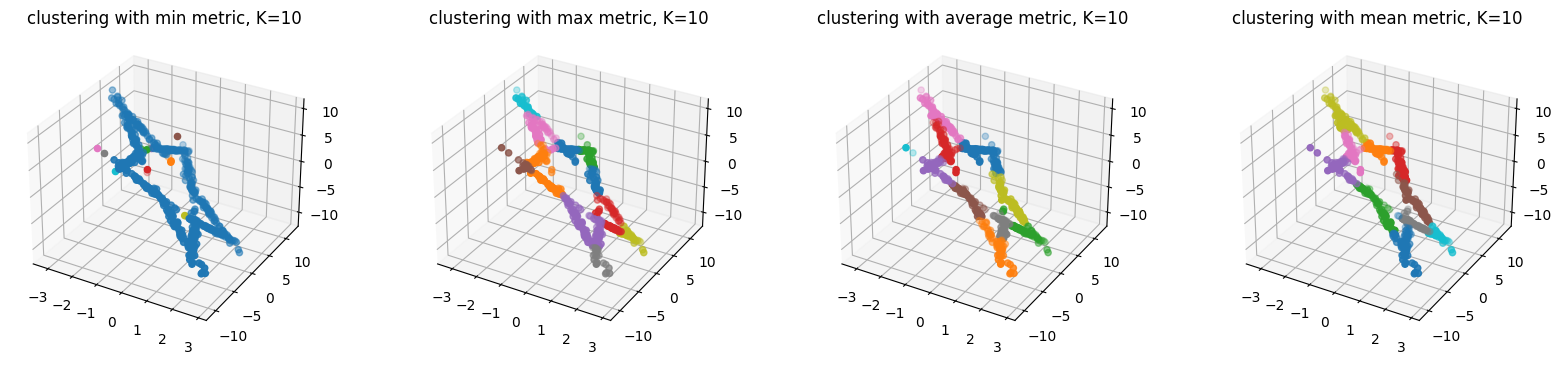

In [144]:
compare_linkage_metrics(d,10)

## results

we could, at this point, expect the min metric to assign almost the whole dataset to the same cluster, and assign their own clusters to each of the outliers due to the linkaing effect, but interesting results emerge whith the other metrics , we see the 'max' metric has a tendecy to pick on th edges of the star, as distinct clusters, and the average/ mean metrics take lines as clusters.
#### we know the data consists of 10 original clusters, but an interesting rwesult emerges when we lower the number of clusters down to $K \leftarrow 5$

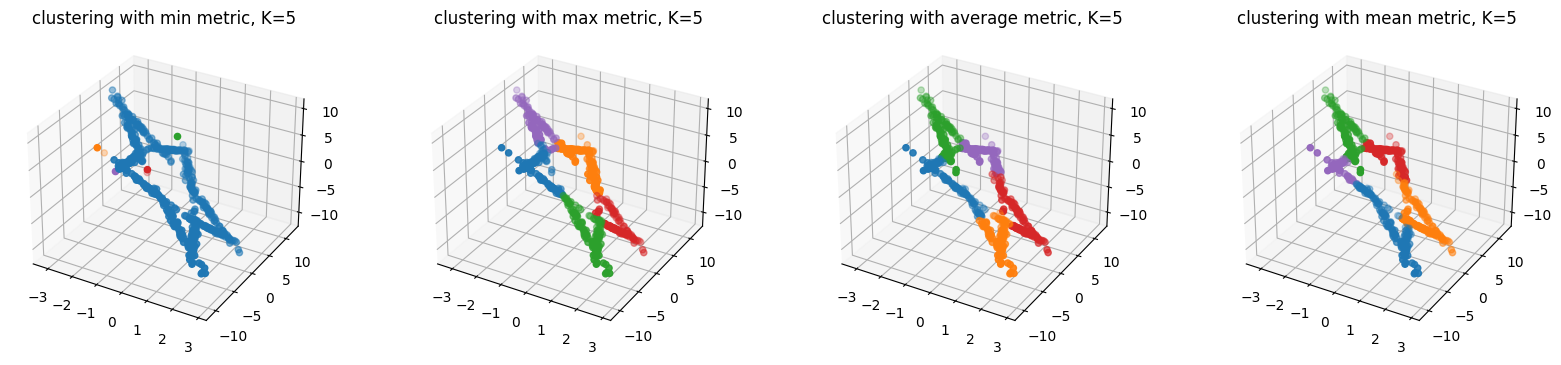

In [146]:
compare_linkage_metrics(d,5)


the sides of the star get clustered almost exactly to their original assignments, but in pairs, according to their location on the star sides a surprising accurate result for all of the metrics, especially for the max metric, which clusterd the original clusters (although in pairs) in astounding accuracy